<a href="https://colab.research.google.com/github/krauseannelize/project-report-traveltide-rewards/blob/main/notebooks/traveltide_03_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Analysis | TravelTide Rewards Program

# Part 3: Customer Segmentation

## 1 - Project Objective

The aim of this project remains to support the Head of Marketing at TravelTide in designing a personalized rewards program that increases customer engagement and retention. Building on the user‑level aggregation, `Part 3` applies segmentation techniques to group customers into distinct profiles based on demographics, travel behavior, and discount responsiveness.

My role as a Data Analyst is to translate these segments into actionable insights, highlighting the unique needs and preferences of each group. This step moves beyond descriptive analysis to deliver a structured view of customer diversity, enabling the design of tailored rewards strategies that resonate with specific segments and drive long‑term loyalty.

## 2 - Data Import & Initial Inspection

### 2.1 Import Packages & Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Google Colab integration
from google.colab import drive

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [Part 2: User‑Level Aggregation](https://colab.research.google.com/drive/1mmQp8b9HsJgX78p4iIyU9u7siCRowECl?usp=sharing), session data was consolidated into user‑level profiles, capturing demographics, spending habits, trip duration, and discount responsiveness. The resulting dataset was exported as `traveltide-user-aggregation.csv`, providing a structured view of customer behavior beyond individual sessions. In this notebook, I reload that aggregated dataset and shift the focus toward customer segmentation, using rule‑based grouping and descriptive analysis to highlight distinct customer profiles whose preferences and behaviors can inform targeted rewards strategies.

### 2.2 Load Dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Read vehicle dataset as pandas DataFrame
user_agg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ms-data/traveltide-user-aggregation.csv')

Mounted at /content/drive


### 2.3 Inspect Dataset

In [3]:
# Inspect shape of sessions dataset
print(f"---DATASET SHAPE---\nRows: {user_agg.shape[0]}\nColumns: {user_agg.shape[1]}")

---DATASET SHAPE---
Rows: 5987
Columns: 49


In [4]:
# Preview user aggregated dataset
user_agg.head()

,user_id,gender,married,has_children,home_country,home_city,home_airport,user_age,account_age,total_sessions,...,status_complete,status_none,category_extended,category_other,category_week,category_weekend,browsing_frequency,booking_frequency,booking_conversion,cancellation_rate
0,23557,f,True,False,usa,new york,lga,66,41,8,...,2,6,1,1,0,0,0.20,0.05,0.25,0.0
1,94883,f,True,False,usa,kansas city,mci,52,34,8,...,2,6,0,1,1,0,0.24,0.06,0.25,0.0
2,101486,f,True,True,usa,tacoma,tcm,52,34,8,...,2,6,2,0,0,0,0.24,0.06,0.25,0.0
3,101961,f,True,False,usa,boston,bos,44,34,8,...,5,3,4,0,0,1,0.24,0.15,0.62,0.0
4,106907,f,True,True,usa,miami,tnt,46,34,8,...,1,6,2,0,0,0,0.24,0.06,0.25,0.5


In [5]:
# Review basic information about sessions dataset
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987 entries, 0 to 5986
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     5987 non-null   int64  
 1   gender                      5987 non-null   object 
 2   married                     5987 non-null   bool   
 3   has_children                5987 non-null   bool   
 4   home_country                5987 non-null   object 
 5   home_city                   5987 non-null   object 
 6   home_airport                5987 non-null   object 
 7   user_age                    5987 non-null   int64  
 8   account_age                 5987 non-null   int64  
 9   total_sessions              5987 non-null   int64  
 10  avg_session_duration        5987 non-null   float64
 11  avg_page_clicks             5987 non-null   float64
 12  avg_clicks_per_min          5987 non-null   float64
 13  avg_seats                   5987 

In [6]:
# Inspect unique values and counts for categorical columns
# Select all columns with dtype 'object' or 'bool'
categorical_cols = user_agg.select_dtypes(include=["object", "bool"]).columns.tolist()

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(user_agg[col].value_counts(dropna=False))
    print(f"Unique values: {user_agg[col].nunique()}")


Column: gender
gender
f    5292
m     695
Name: count, dtype: int64
Unique values: 2

Column: married
married
False    3351
True     2636
Name: count, dtype: int64
Unique values: 2

Column: has_children
has_children
False    4036
True     1951
Name: count, dtype: int64
Unique values: 2

Column: home_country
home_country
usa       4980
canada    1007
Name: count, dtype: int64
Unique values: 2

Column: home_city
home_city
new york          677
los angeles       325
toronto           225
chicago           195
houston           185
                 ... 
amarillo           14
modesto            14
spokane            13
salt lake city     13
newport news       13
Name: count, Length: 105, dtype: int64
Unique values: 105

Column: home_airport
home_airport
lga    360
lax    325
jfk    317
dal    116
yyc    101
      ... 
pob      6
ska      6
edf      5
geg      4
sff      3
Name: count, Length: 159, dtype: int64
Unique values: 159

Column: top_airline
top_airline
american airlines    1009
Na

In [7]:
# Diagnostic and Statistical Summary
# Select numeric columns only
numeric_cols = user_agg.select_dtypes(include=['int64','float64'])

# Compute quartiles and IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Compute supporting stats
mean_vals = numeric_cols.mean()
median_vals = numeric_cols.median()
min_vals = numeric_cols.min()
max_vals = numeric_cols.max()
std_vals = numeric_cols.std()

# Build summary DataFrame
summary = pd.DataFrame({
    "Min": min_vals
    , "Q1": Q1
    , "Median": median_vals
    , "Q3": Q3
    , "IQR": IQR
    , "Upper Bound": upper_bound
    , "Max": max_vals
    , "Mean": mean_vals
    , "STD": std_vals
})

# Define reusable function to classify outliers
def classify_outliers(row):
    diff = row["Max"] - row["Upper Bound"]
    if diff <= 0:
        return "No"
    elif diff <= row["IQR"]:
        return "Some"
    elif diff <= 2 * row["IQR"]:
        return "Clear"
    else:
        return "Strong"

# Add a Outlier flag by executing the classify_outlier function
summary["Outliers"] = summary.apply(classify_outliers, axis=1)

# Define reusable function to determine skewness by comparing mean vs median
def classify_skew_simple(mean, median):
    if np.isclose(mean, median, rtol=0.05):  # within ~5% relative tolerance
        return "Balanced"
    elif mean > median:
        return "Possible Right"
    else:
        return "Possible Left"

# Add a Skewness flag by executing the classify_skew function
summary["Skewness"] = [
    classify_skew_simple(mean_vals[col], median_vals[col])
    for col in summary.index
]

# Round for readability
summary = summary.round(2)
summary

,Min,Q1,Median,Q3,IQR,Upper Bound,Max,Mean,STD,Outliers,Skewness
user_id,23557.00,517146.50,540572.00,574142.00,56995.50,659635.25,844489.00,545490.03,64834.74,Strong,Balanced
user_age,18.00,35.00,43.00,50.00,15.00,72.50,89.00,42.35,12.06,Clear,Balanced
account_age,19.00,22.00,23.00,23.00,1.00,24.50,41.00,22.86,1.17,Strong,Balanced
total_sessions,4.00,8.00,8.00,8.00,0.00,8.00,12.00,8.13,0.54,Strong,Balanced
avg_session_duration,0.52,1.54,1.93,2.44,0.90,3.79,33.75,3.10,4.00,Strong,Possible Right
avg_page_clicks,4.12,12.38,15.50,19.50,7.12,30.18,109.12,17.48,8.71,Strong,Possible Right
avg_clicks_per_min,6.32,7.95,8.02,8.08,0.13,8.28,8.33,7.95,0.27,Some,Balanced
avg_seats,0.00,0.12,0.33,0.50,0.38,1.07,2.00,0.35,0.26,Strong,Balanced
avg_checked_bags,0.00,0.00,0.12,0.25,0.25,0.62,1.89,0.17,0.18,Strong,Possible Right
num_trip_discounts,0.00,1.00,2.00,3.00,2.00,6.00,7.00,2.19,1.26,Some,Possible Right


The diagnostic summary reveals that many variables in the aggregated dataset are skewed and show clear or strong outliers, particularly in spending, trip costs, and discount usage. Right‑skewed distributions in measures like trip distance, discount amounts, and ancillary purchases indicate that while the majority of users follow predictable patterns, a smaller subset engages in much higher‑value or atypical behaviors. These extremes are important to note for segmentation, as they may represent distinct customer profiles whose preferences and responsiveness differ from the broader base.

## 3 - Segmentation Framework

### 3.1 Segmentation Dimensions & Rules

The segmentation tree is built on three core dimensions: `booking status`, `family status`, and `travel duration` (with category flags for weekend and week trips). This yields a clean set of segments that are campaign‑ready.

#### Step 1: Booking Status

- **Looker** → `total_trips == 0`
- **Booker** → `total_trips ≥1`

#### Step 2: Family Status (for Bookers)

- **With Children** → `has_children == True`

  - **Sprinters** → `0 <= avg_trip_duration_days <= 5`
  - **Voyagers** → `avg_trip_duration_days > 5`

- **Without Children** → `has_children == False`

  - **Trailblazers** → `category_week == True` and `0 < avg_trip_duration_days <= 6` and `avg_seats <= 1`
  - **Weekenders** → `category_weekend == True` and `0 < avg_trip_duration_days <= 3`
  - **Go‑Getters** → `0 < avg_trip_duration_days <= 5`
  - **Adventurers** → `avg_trip_duration_days >= 5`

### 3.2 Customer Segments

| Nr | Segment | Description |
| --- | --- | --- |
| 1 | **Lookers** | No bookings, high browsing |
| 2 | **Sprinters** | Families with short stays of 0–5 days |
| 3 | **Voyagers** | Families with extended vacations of 6+ days |
| 4 | **Trailblazers** | No children, short weekday stays of 0–6 days with ≤1 seat (business focus) |
| 5 | **Weekenders** | No children, short weekend stays of 0–3 days |
| 6 | **Go-Getters** | No children, short stays of 0–5 days |
| 7 | **Adventurers** | No children, extended trips of 7+ days |

### 3.3 Customer Segment Allocation

In [16]:
def assign_segment(row):
    # Step 1: Booking Status
    if row['total_trips'] == 0:
        return "Lookers"

    # Step 2: Family Status
    if row['has_children']:
        if 0 <= row['avg_trip_duration_days'] <= 5:
            return "Sprinters"   # Family Short-Stays
        elif row['avg_trip_duration_days'] > 5:
            return "Voyagers"    # Family Extended Vacations
    else:
        # Without children
        if row.get('category_week', False) and 0 < row['avg_trip_duration_days'] <= 6 and row['avg_seats'] <= 1:
            return "Trailblazers"  # Business
        elif row.get('category_weekend', False) and 0 < row['avg_trip_duration_days'] <= 3:
            return "Weekenders"    # Short weekend stays
        elif 0 < row['avg_trip_duration_days'] <= 5:
            return "Go-Getters"    # Mid-Week travellers
        elif row['avg_trip_duration_days'] >= 5:
            return "Adventurers"   # Extended, no children

    # Fallback if no condition matched
    return "Unclassified"

# Apply to dataframe
user_agg['segment'] = user_agg.apply(assign_segment, axis=1)

# View counts per segment
user_agg['segment'].value_counts()

,count
segment,
Sprinters,1767
Go-Getters,1762
Trailblazers,1557
Lookers,479
Weekenders,333
Adventurers,59
Voyagers,30


### 3.4 Visualization of Segments

To illustrate how the segmentation framework translates into observable customer groups, I visualize both the distribution of users across segments and their booking behaviours.

#### 3.4.1 Distribution of Segments

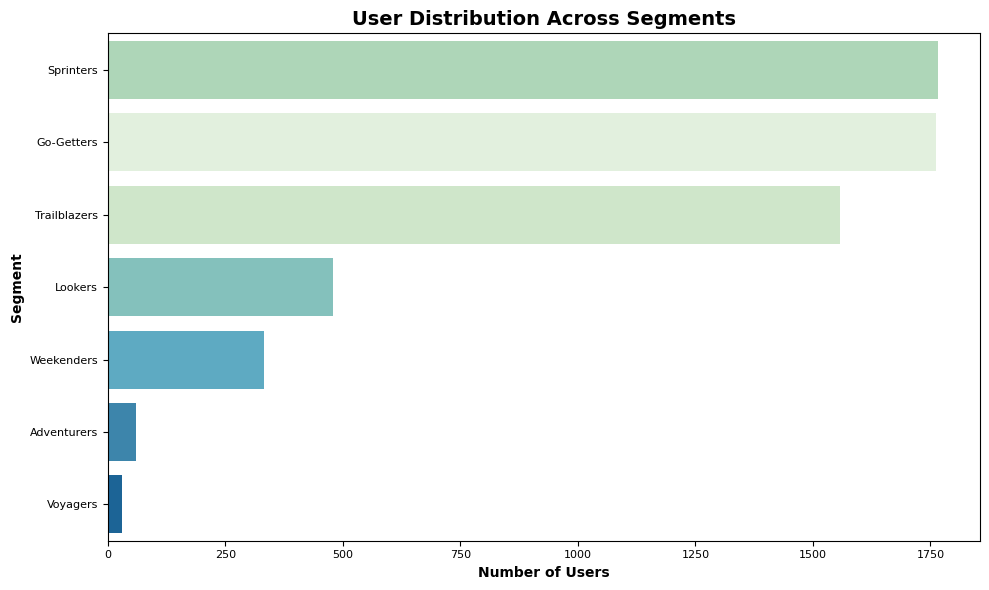

In [19]:
# Set plot figure
plt.figure(figsize=(10, 6))

# Countplot of segments
sns.countplot(
    data=user_agg
    , y="segment"
    , order=user_agg['segment'].value_counts().index
    , palette="GnBu"
    , hue="segment"
)

# Add titles and labels
plt.title("User Distribution Across Segments", fontsize=14, fontweight="bold")
plt.xlabel("Number of Users", fontsize=10, fontweight="bold")
plt.ylabel("Segment", fontsize=10, fontweight="bold")
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)

# Display plot
plt.tight_layout()
plt.show()

The visualization shows that all users are successfully classified into clear segments. The largest groups are `Sprinters`, `Go‑Getters`, and `Trailblazers`, while `Weekenders`, `Adventurers`, and `Voyagers` represent smaller but distinct niches. The presence of `Lookers` ensures browsing behavior is also captured.

Overall, the distribution confirms that the segmentation framework is robust, interpretable, and ready to support campaign targeting.

#### 3.4.2 Booking Behaviour by Segment

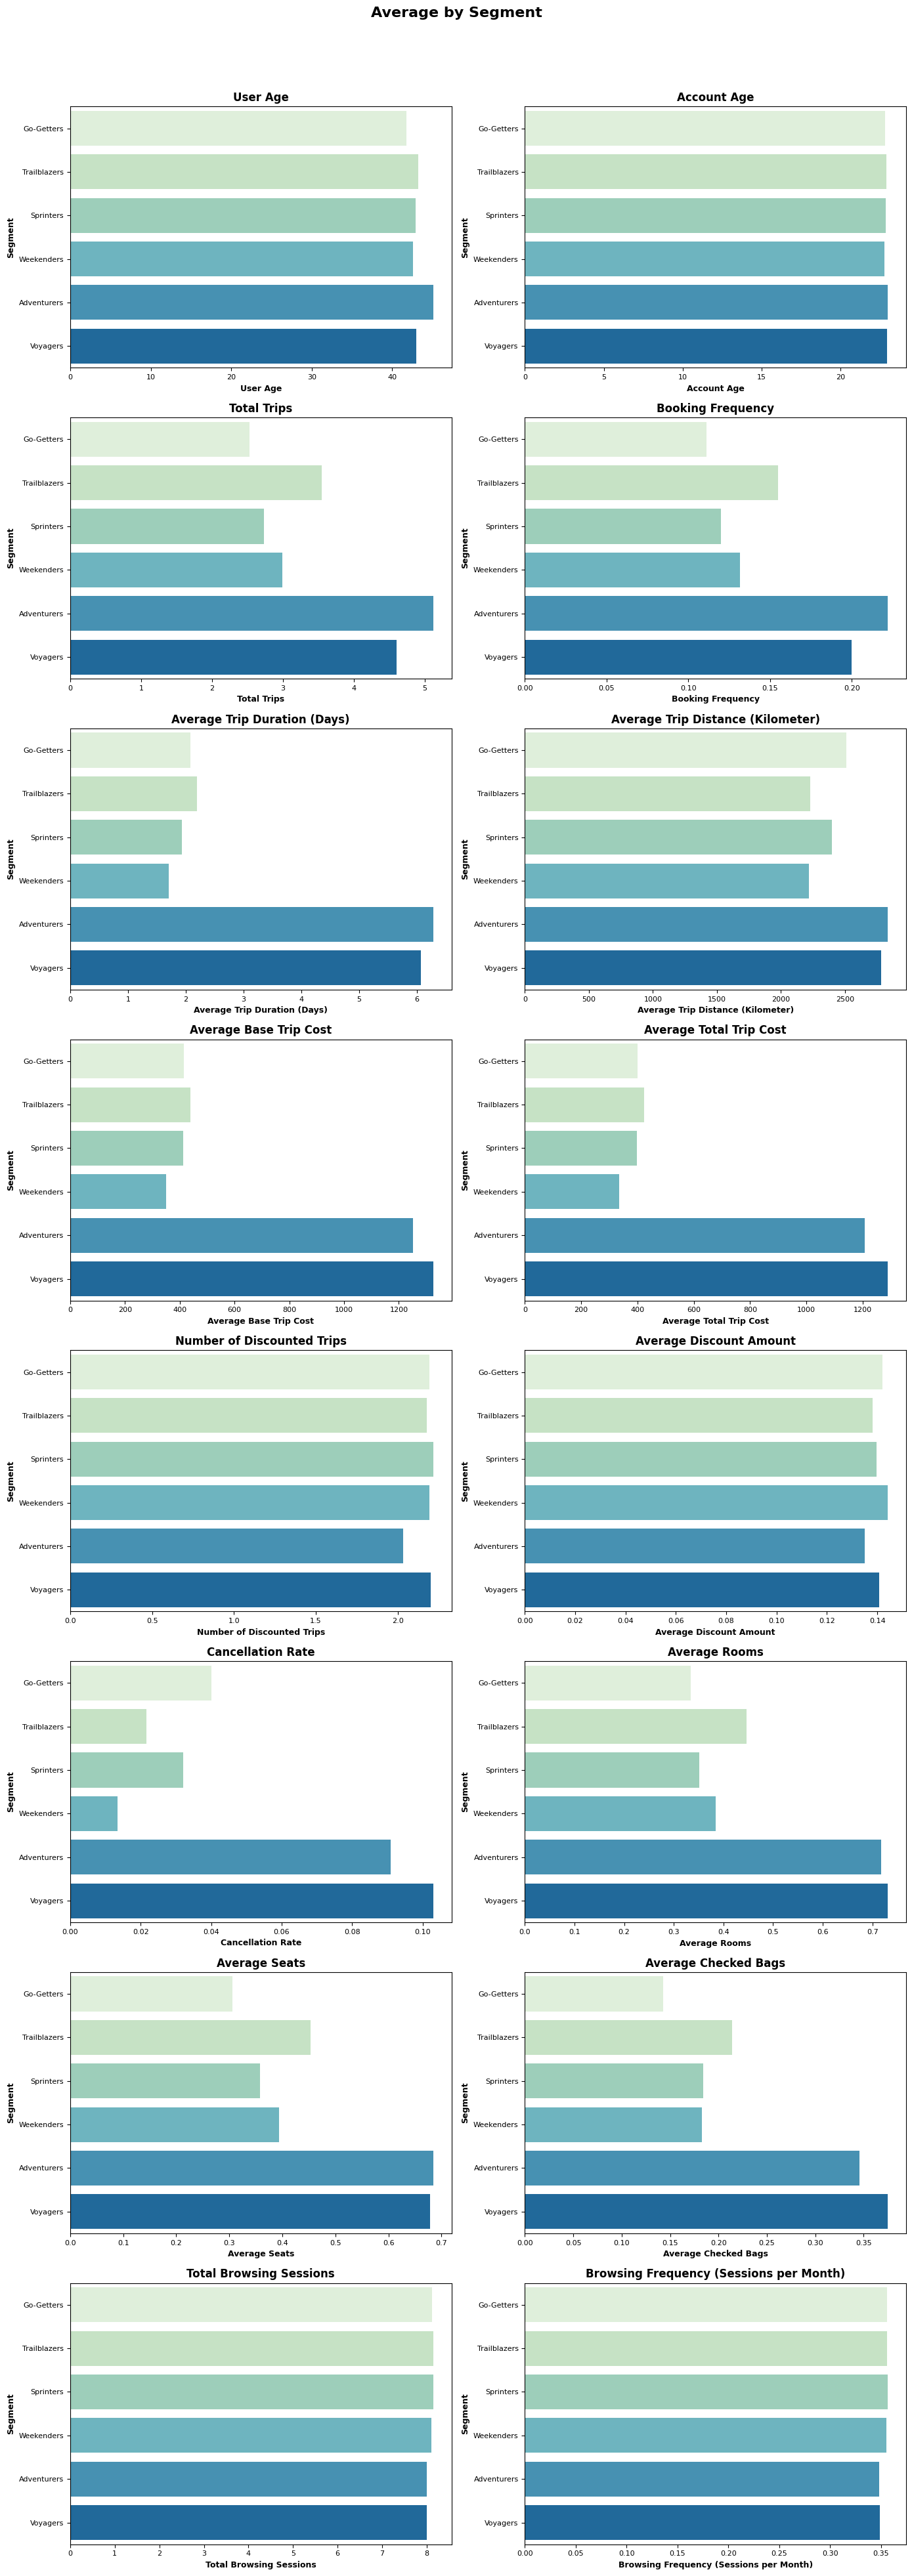

In [22]:
# Filter out Lookers to consider booking behaviour
segment_groups = user_agg[user_agg["segment"] != "Lookers"].copy()

# Function to create a barplot of user segment distribution
def plot_user_segments(df, col, label, ax):
    sns.barplot(
        data=df
        , x=col
        , y="segment"
        , palette="GnBu"
        , hue="segment"
        , estimator="mean"
        , errorbar=None
        , ax=ax
    )
    ax.set_title(label, fontsize=12, fontweight="bold")
    ax.set_xlabel(label, fontsize=9, fontweight="bold")
    ax.set_ylabel("Segment", fontsize=9, fontweight="bold")
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Columns to iterate over with improved labels
cols_segment_compare = {
    "user_age": "User Age"  # 1
    , "account_age": "Account Age"  # 2
    , "total_trips": "Total Trips"  # 3
    , "booking_frequency": "Booking Frequency"  # 4
    , "avg_trip_duration_days": "Average Trip Duration (Days)"  # 5
    , "avg_trip_distance_km": "Average Trip Distance (Kilometer)"  # 6
    , "avg_base_trip_cost": "Average Base Trip Cost"  # 7
    , "avg_total_trip_cost": "Average Total Trip Cost" # 8
    , "num_trip_discounts": "Number of Discounted Trips"  # 9
    , "avg_trip_discount_amount": "Average Discount Amount"  # 10
    , "cancellation_rate": "Cancellation Rate"  # 11
    , "avg_rooms": "Average Rooms"  # 12
    , "avg_seats": "Average Seats" # 13
    , "avg_checked_bags": "Average Checked Bags" # 14
    , "total_sessions": "Total Browsing Sessions"  # 15
    , "browsing_frequency": "Browsing Frequency (Sessions per Month)"  # 16
}

# Set plot figure with subplots (8 rows × 2 cols = 16 plots)
fig, axes = plt.subplots(8, 2, figsize=(14, 40))
axes = axes.flatten()

# Create a barplot for each variable
for i, (col, label) in enumerate(cols_segment_compare.items()):
    plot_user_segments(segment_groups, col, label, axes[i])

# Display plot
plt.suptitle("Average by Segment", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The booking behaviour analysis highlights that while browsing sessions and frequency are relatively balanced across all segments, differences emerge in booking frequency, trip volume, and spending patterns. This suggests that engagement is not driven by browsing activity alone but by distinct travel behaviours that align with the segmentation logic. The consistency in account age and user age averages across groups indicates that these segments are not artifacts of demographic skew but reflect genuine behavioural distinctions. Importantly, extended‑stay groups such as Adventurers and Voyagers show higher spend per trip, while discount uptake remains evenly distributed, reinforcing the insights from Parts 1 and 2 and confirming the robustness of the segmentation framework.

## 4 - Key Findings and Validation

### 4.1 Behavioural Insights

- **Browsing activity is balanced:** Similar averages in sessions and frequency across segments show that engagement is not differentiated by browsing, but by booking behaviour.
- **Booking frequency and trip volume vary:** `Trailblazers`, `Adventurers`, and `Voyagers` book more often and take more trips, confirming behavioural segmentation.
- **Spending patterns diverge:** `Adventurers` and `Voyagers` spend significantly more per trip, validating their classification as extended‑stay, higher‑value travelers.
- **Discount uptake is consistent:** All segments use discounts at similar rates, suggesting promotions appeal broadly rather than to specific groups.
- **Balanced demographics:** Account age and user age averages are stable across segments, confirming that differences are behavioural rather than demographic.

### 4.2 Validation of Segmentation

These patterns reinforce [Part 1](https://colab.research.google.com/drive/1rMwRBKmkhHxbGOm-ZipeaudbIYUoIlTs?usp=sharing) and [Part 2](https://colab.research.google.com/drive/1mmQp8b9HsJgX78p4iIyU9u7siCRowECl?usp=sharing) by showing that the rules cleanly separate short‑stay vs. extended‑stay, family vs. non‑family, and business vs. leisure travellers in ways that are observable in booking data.

## 5 - Reward Strategy by Segment

### 5.1 Segment-Reward Mapping

| Segment | Suggested Reward(s) | Rationale |
| --- | --- | --- |
| **Lookers** | Exclusive discounts & browsing‑based offers | Motivates non‑bookers to convert. Discounts tied to browsing behaviour create urgency. |
| **Sprinters** | Free hotel meal | Families on short stays value convenience. A meal reduces friction and adds comfort. |
| **Voyagers**   | One night free hotel with flight | Extended family vacations benefit most from bundled perks. This increases loyalty and spend. |
| **Trailblazers** | Lounge access | Business‑focused travellers prize comfort and productivity. Lounge access reduces stress and builds loyalty. |
| **Weekenders** | Free checked bag | Short leisure trips often involve budget airlines and adding  bag perk adds tangible value. |
| **Go‑Getters** | Exclusive discounts on weekday stays | Price‑sensitive, short‑stay travellers respond well to targeted discounts that match their booking pattern. |
| **Adventurers** | Premium experience upgrade (e.g., room upgrade, late checkout) | Extended solo/couple trips skew higher spend and experiential rewards reinforce their premium positioning. |


### 5.2 Key Takeaways

- Rewards are **aligned with segment personality** with convenience for families, flexibility for business travellers, value for budget‑conscious, and premium perks for extended‑stay groups.  
- Marketing’s suggestions are well‑covered, but tailoring ensures each segment feels uniquely recognized.  
- This strategy ensures **efficiency** (rewards match behaviour), **accuracy** (no overlap or wasted perks), and **effectiveness** (clear incentive to engage with TravelTide Rewards).